## Вычислительный эксперимент

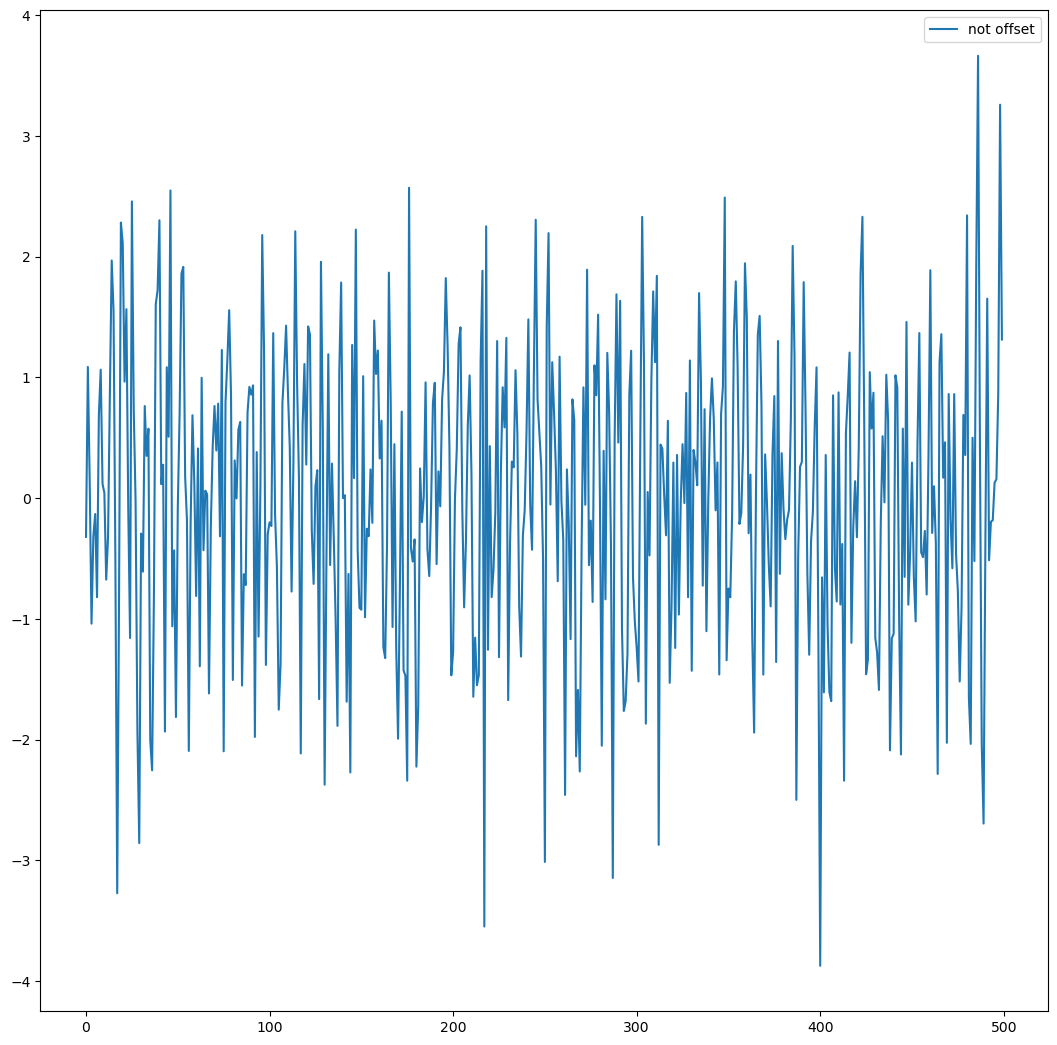

In [24]:
import numpy as np
import matplotlib.pyplot as plt

N = 500
samples = np.array([np.arange(N) + i for i in range(N)],dtype=float)
sinuses = np.sin(samples) # синусы

plt.figure(figsize = [13, 13])

randoms = np.array([np.random.normal(loc = 0, scale = 1) for i in range(1, N + 1)], dtype=float) # зашумляем нормальным распределением


not_offset = sinuses[0] + randoms
offset = sinuses[0] + np.random.normal(loc=0, scale=1, size=N)
another = sinuses[0] + np.random.uniform(low=0, high=1, size=N)

plt.plot(samples[0], not_offset, label = 'not offset')
#plt.plot(samples[0], offset, label = 'offset')
#plt.plot(samples[0], another, label = 'ANOTHER')
plt.legend()

## Подключение библиотек

In [25]:
import torch
import torchsde

In [27]:
import torch
from torch import nn

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

In [28]:
import statsmodels.api as sm
print(len(not_offset))

diffs_non_offset = np.array([not_offset[i] - not_offset[i + 1] for i in range(0, N - 1)]) # разницы элементов временного ряда - так оцениваем производную
brownian_size = 1

autocorr = sm.tsa.acf(not_offset) # корреляция ряда????

print(len(autocorr))

500
27


## Настройка модели

In [29]:
#import pytorch_forecasting
import statsmodels.api as sm

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'stratonovich'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size)
        self.sigma = torch.nn.Linear(state_size, state_size * brownian_size)
        #self.sigma = 

    # Drift
    def f(self, t, y):
        return torch.from_numpy(np.interp(y.numpy(), not_offset[:N-1], diffs_non_offset)).to(torch.float32) # дрифт - это интерполяционная функция, по значению временного ряда возвращающая производнаю в этой точке 

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, state_size, brownian_size) # диффузия определяется рандомно(пока что)

## Прогноз

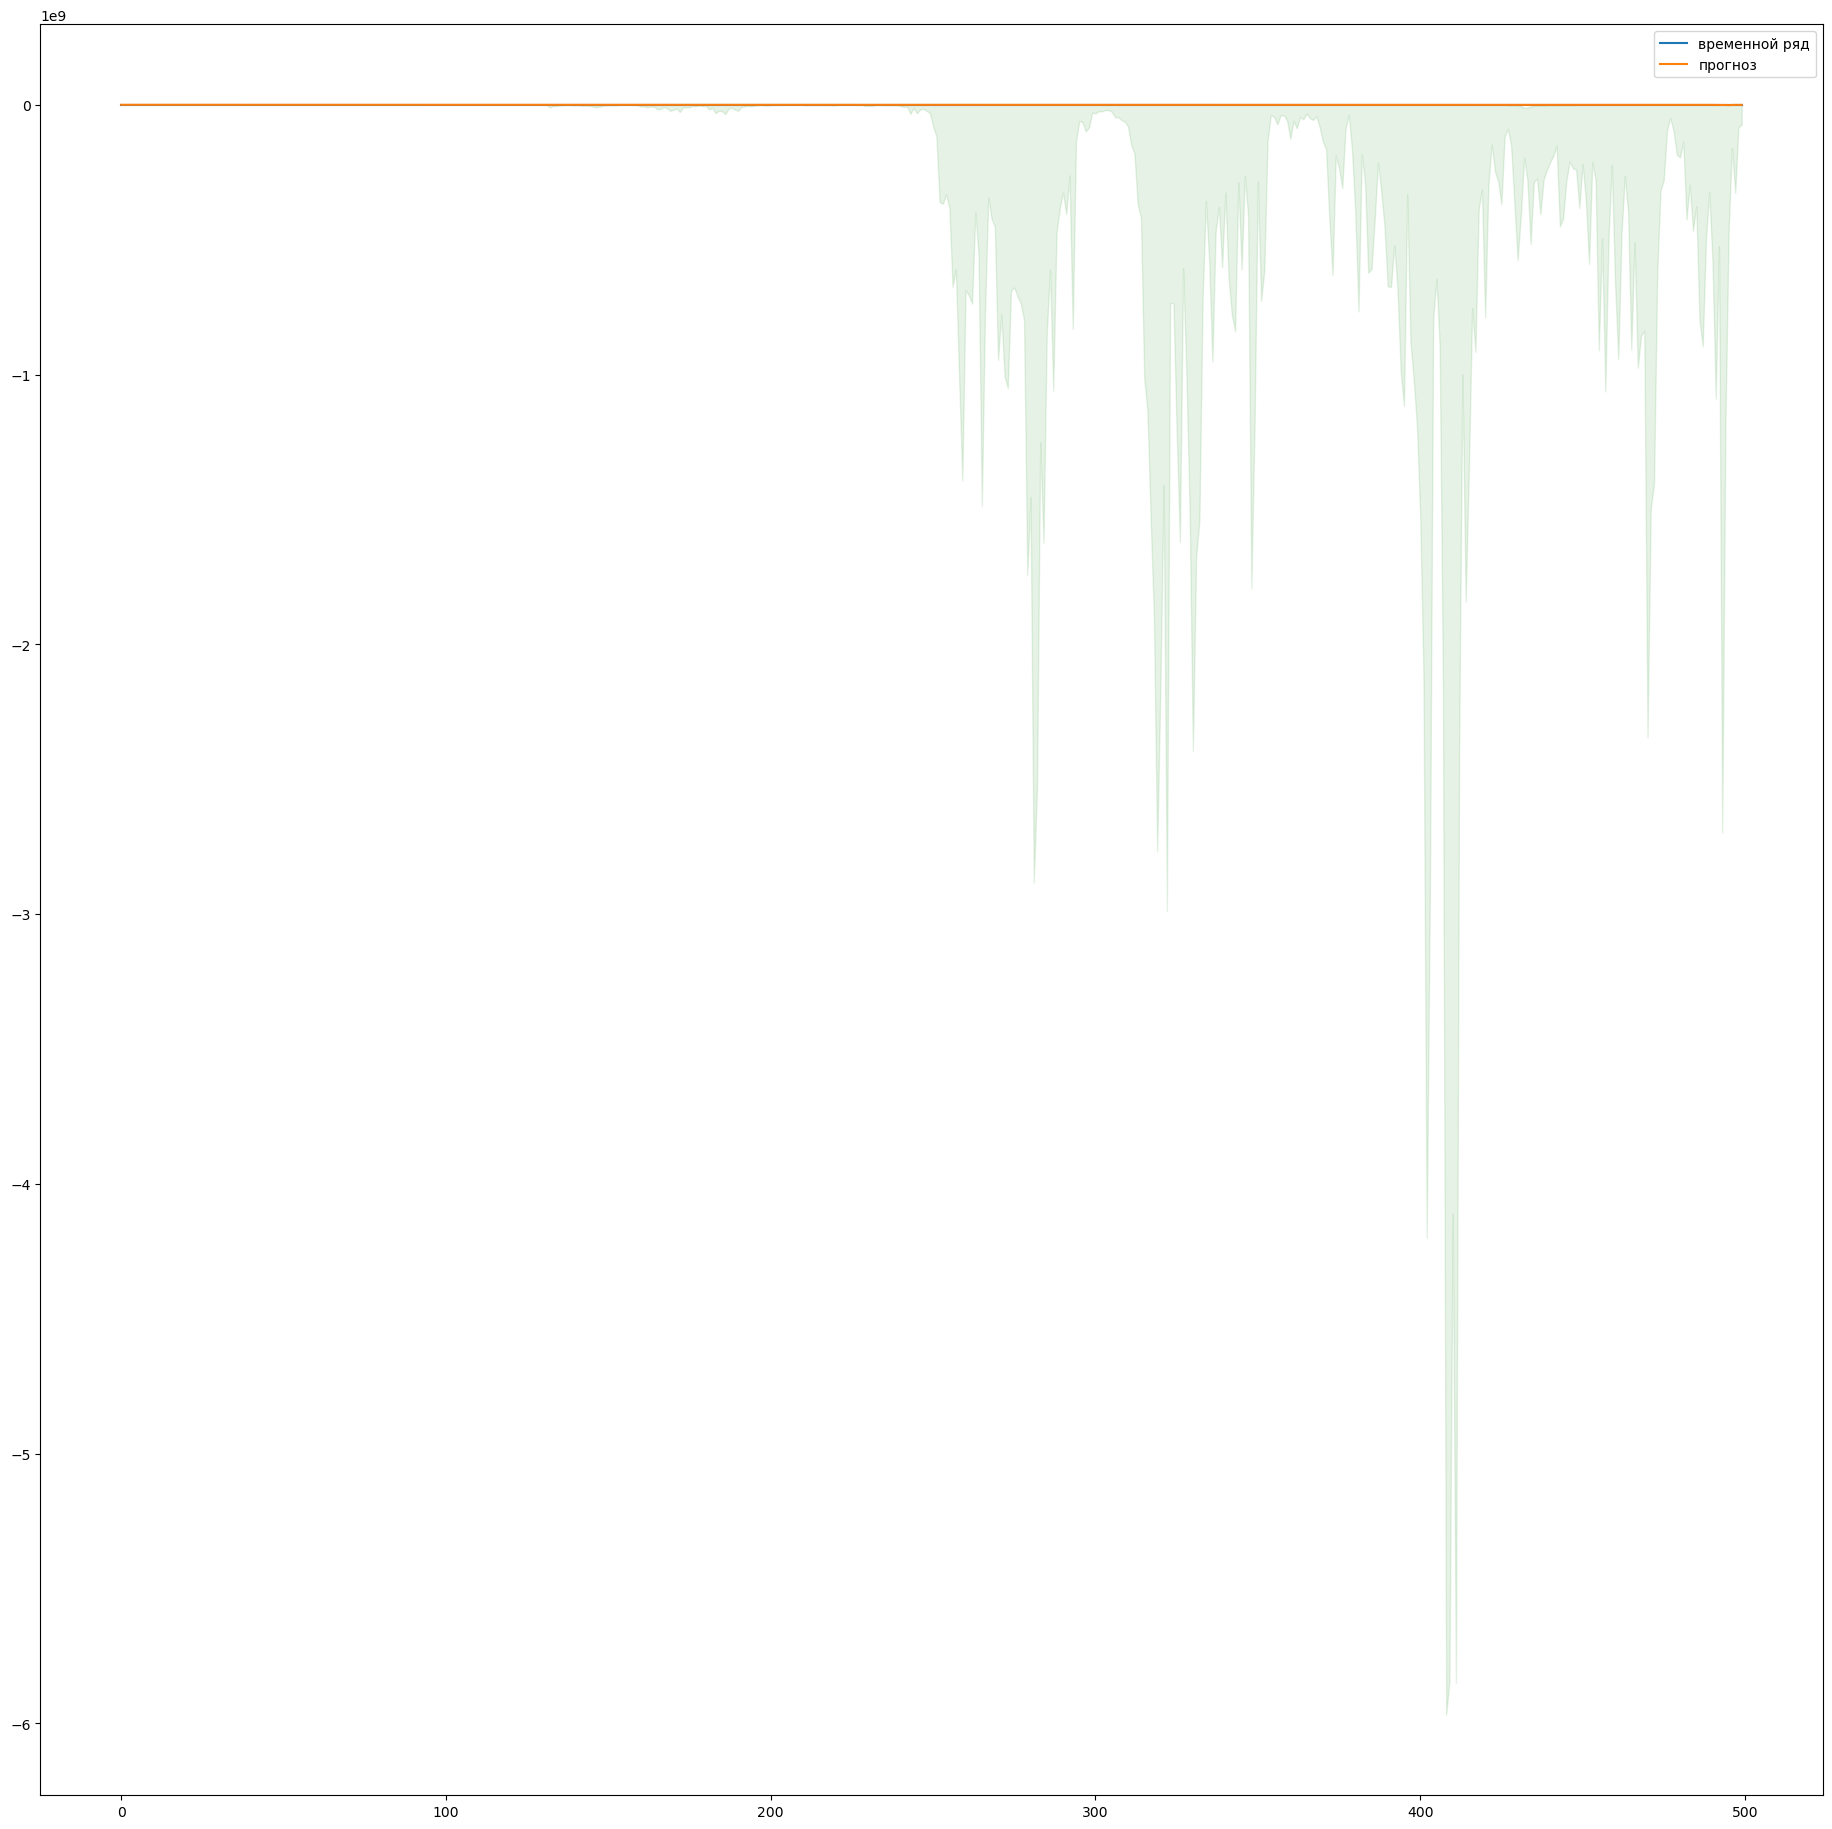

In [30]:
batch_size, state_size, t_size = 12, 1, N # 12 прогнозов одномерного временного ряда из N элементов

# почему нельзя делать слишком много прогнозов(не 100 скажем, а 12)? потому что, когда мы будем строить доверительный интервал и соотвественно оценивать пороги 
# значений вр.ряда сверху и снизу квантилями мы будем стабильно получать постепенно расширяющуюся воронку из-за закона повторного логарифма
# именно так, ведь модель neural sde завязана на винеровском процессе, границы которого асимптотически стремятся к оценкам из него
# чтобы не получать такой бесполезный прогноз - следует брать малое количество предсказаний

sde = SDE()
ts = torch.linspace(0, N, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=not_offset[0])


sde.sde_type = "stratonovich"
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='euler_heun')  # (t_size, batch_size, state_size) = (100, 3, 1).


ts = ts.cpu()
ys = ys.squeeze().t().cpu()
plt.figure(figsize=[23,23])

avg = np.array([sample.numpy() for i, sample in enumerate(ys)], dtype=float) # распаковываем полученные аппроксимации

avg_1  = np.quantile(avg, 0.75, axis=0) # диапазоны довер.интервалов
avg_2  = np.quantile(avg, 0.25, axis=0)

plt.fill_between(np.arange(N), avg_2, avg_1, color='green',alpha=0.1)
plt.plot(np.arange(N), not_offset, label='временной ряд')

plt.plot(np.arange(N), avg[0], label='прогноз')
plt.legend()

plt.show()

## Фазовые траектории

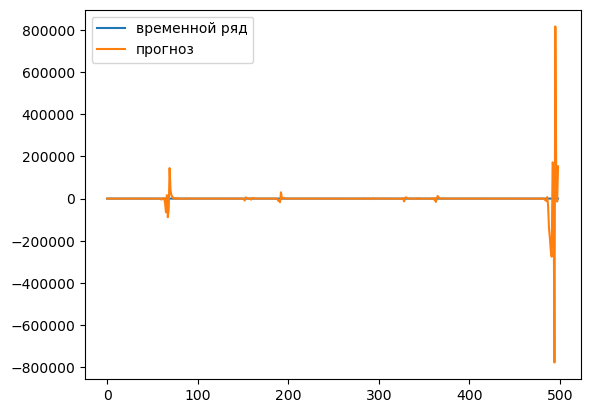

In [31]:
from numpy import diff

dx = 1
phase_tr_prognoz = diff(avg[0])/dx
phase_tr_orig = diff(not_offset)/dx

plt.plot(np.arange(N - 1), phase_tr_orig, label='временной ряд')
plt.plot(np.arange(N - 1), phase_tr_prognoz, label='прогноз')

plt.legend()

plt.show()

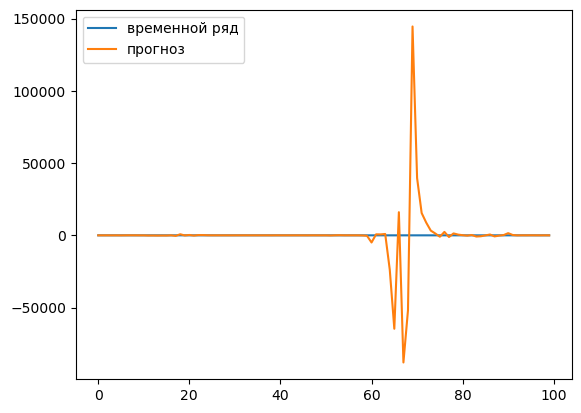

In [32]:
srezka = 100

plt.plot(np.arange(srezka), phase_tr_orig[:srezka], label='временной ряд')
plt.plot(np.arange(srezka), phase_tr_prognoz[:srezka], label='прогноз')

plt.legend()
plt.show()

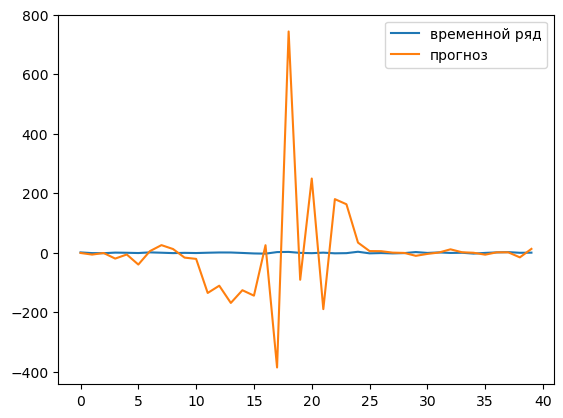

In [33]:
srezka = 40

plt.plot(np.arange(srezka), phase_tr_orig[:srezka], label='временной ряд')
plt.plot(np.arange(srezka), phase_tr_prognoz[:srezka], label='прогноз')

plt.legend()
plt.show()

In [34]:
print(len(phase_tr_orig), len(phase_tr_prognoz))

499 499


In [35]:
print(phase_tr_orig)

[ 1.40762514 -0.93847419 -1.187616    0.72485196  0.18301604 -0.68931358
  1.51163794  0.37265111 -0.94587952 -0.07449749 -0.71786651  0.35329984
  1.1879257   1.10171625 -0.41505441 -2.08206719 -2.74382838  2.47360047
  3.08141239 -0.16773757 -1.14972081  0.60030222 -1.63860946 -1.08509522
  3.61598687 -1.72191912 -0.75764937 -1.90984148 -0.92483921  2.56312875
 -0.31523285  1.37166276 -0.41260657  0.22493192 -2.58088124 -0.2479528
  1.45902303  2.40090892  0.11707279  0.57806433 -2.18529992  0.16066414
 -2.20969937  3.0170713  -0.57549028  2.03926595 -3.60908583  0.62890083
 -1.38083426  1.73394295  0.78628344  1.15284606  0.05546618 -1.73413196
 -0.36747949 -1.90738423  1.88929578  0.89055608 -0.5536486  -0.94317378
  1.22207649 -1.80384253  2.38959959 -1.42868727  0.49343311 -0.03003588
 -1.64941579  1.38334377  0.65488521  0.34234424 -0.36873769  0.38819676
 -1.09880218  1.54349512 -3.32367325  2.89094067  0.35241064  0.40954439
 -0.70498726 -2.35734924  1.81845351 -0.31470798  0.

## Оцениваем их корреляцию??? (здесь метод Сугихары такой, каким я его понял - пока что)

In [36]:
import math
import random

def pyrson(orig, prognoz):
    return np.sum((orig - np.mean(orig)) * (prognoz - np.mean(prognoz))) / np.linalg.norm(orig - np.mean(orig)) / np.linalg.norm(prognoz - np.mean(prognoz))


A = np.array([[phase_tr_orig[math.ceil((i + j) / 2)] for i in range(39)] for j in range(39)], dtype=float)
B = np.array([[phase_tr_prognoz[math.ceil((i + j) / 2)] for i in range(39)] for j in range(39)], dtype=float)

cnt_iter = 400
corr = 0

for i in range(cnt_iter):
    #print(random.choice(A))
    corr += pyrson(random.choice(A), random.choice(B))
    #print(corr)

print(corr / cnt_iter)

-0.005364436689958858


Коэффицент маленький, хоть траектории и должны быть коррелированы(как оригинал и его же прогноз)

Вердикт: Надо продолжать эксперименты